In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

torch.manual_seed(42)
np.random.seed(42)


In [ ]:
class DataGenerator(nn.Module):
    """
    Generates a n-dimensional vector y from a scalar input x.
    """
    def __init__(self, input_size=1, output_size=100):
        super(DataGenerator, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        with torch.no_grad():
            self.linear.weight.fill_(0.5)
            self.linear.bias.fill_(0.1)

    def forward(self, x):
        return self.linear(x)


In [ ]:
class GeneratedDataset(Dataset):
    def __init__(self, generator, num_samples=1000, noise_std=0.1):
        super(GeneratedDataset, self).__init__()
        self.generator = generator
        self.num_samples = num_samples
        self.x = torch.linspace(-10, 10, steps=num_samples).unsqueeze(1)  # Shape: [num_samples, 1]
        with torch.no_grad():
            self.y = self.generator(self.x)
            self.y += torch.randn_like(self.y) * noise_std

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


In [ ]:
class InverseMLP(nn.Module):
    """
     Maps a n-dimensional vector y back to a scalar input x.
    """
    def __init__(self, input_size=100, output_size=1, hidden_sizes=[100, 50], activation='ReLU'):
        super(InverseMLP, self).__init__()
        layers = []
        prev_size = input_size
        act_fn = self.get_activation(activation)

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(act_fn)
            prev_size = hidden_size
        layers.append(nn.Linear(prev_size, output_size))
        self.network = nn.Sequential(*layers)

    def get_activation(self, activation):
        activations = {
            'ReLU': nn.ReLU(),
            'Sigmoid': nn.Sigmoid(),
            'Tanh': nn.Tanh(),
            'LeakyReLU': nn.LeakyReLU()
        }
        return activations.get(activation, nn.ReLU())

    def forward(self, y):
        return self.network(y)


In [ ]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for y_batch, x_batch in dataloader:
        y_batch = y_batch.to(device)
        x_batch = x_batch.to(device)

        optimizer.zero_grad()
        x_pred = model(y_batch)
        loss = criterion(x_pred, x_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * y_batch.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss


In [ ]:
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for y_batch, x_batch in dataloader:
            y_batch = y_batch.to(device)
            x_batch = x_batch.to(device)
            x_pred = model(y_batch)
            loss = criterion(x_pred, x_batch)
            running_loss += loss.item() * y_batch.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss


In [ ]:
def plot_losses(train_losses, val_losses, config):
    plt.figure(figsize=(10,6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f"Training and Validation Losses\nConfig: Hidden Sizes={config['hidden_sizes']}, Activation={config['activation']}")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_predictions(model, dataloader, device):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for y_batch, x_batch in dataloader:
            y_batch = y_batch.to(device)
            x_batch = x_batch.to(device)
            x_pred = model(y_batch)
            all_preds.append(x_pred.cpu().numpy())
            all_targets.append(x_batch.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0).flatten()
    all_targets = np.concatenate(all_targets, axis=0).flatten()

    # Plotting a subset for clarity
    plt.figure(figsize=(10,6))
    plt.scatter(all_targets, all_preds, s=10, alpha=0.5)
    plt.plot([all_targets.min(), all_targets.max()], [all_targets.min(), all_targets.max()], 'r--')
    plt.title("MLP2 Predictions vs. True x Values")
    plt.xlabel("True x")
    plt.ylabel("Predicted x")
    plt.grid(True)
    plt.show()


Using device: cpu

Statistics of y (First Component):
Mean: 0.0990
Std Dev: 2.8948
Min: -5.0901
Max: 5.1963

Training InverseMLP with config: Hidden Sizes=[100, 50], Activation=ReLU, LR=0.01

Training InverseMLP with config: Hidden Sizes=[200, 100], Activation=Tanh, LR=0.001

Training InverseMLP with config: Hidden Sizes=[300, 150, 75], Activation=Sigmoid, LR=0.005

Training InverseMLP with config: Hidden Sizes=[120, 60], Activation=LeakyReLU, LR=0.01
Epoch [1/100] - Train Loss: 5.329167, Val Loss: 0.679443
Epoch [20/100] - Train Loss: 0.038713, Val Loss: 0.001028
Epoch [40/100] - Train Loss: 0.000766, Val Loss: 0.000759
Epoch [60/100] - Train Loss: 0.044226, Val Loss: 0.112538
Epoch [80/100] - Train Loss: 0.000906, Val Loss: 0.001302
Epoch [100/100] - Train Loss: 0.002206, Val Loss: 0.002188


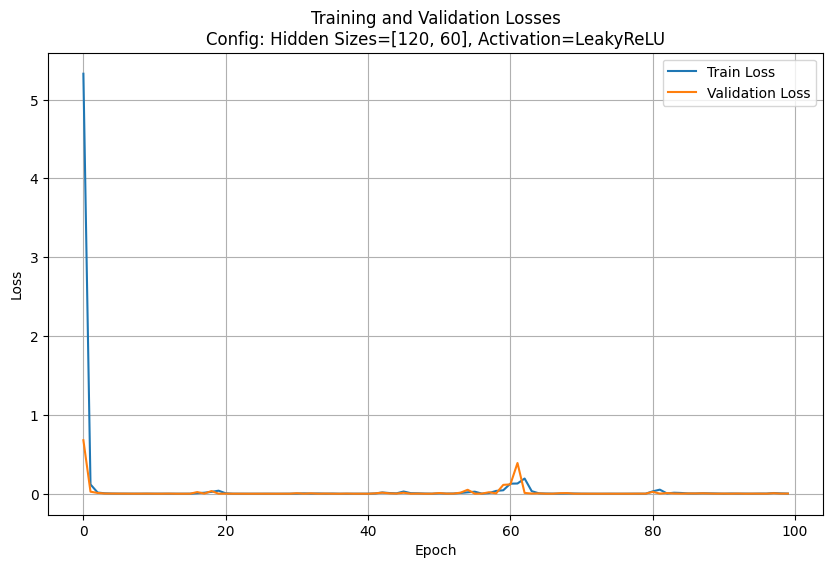

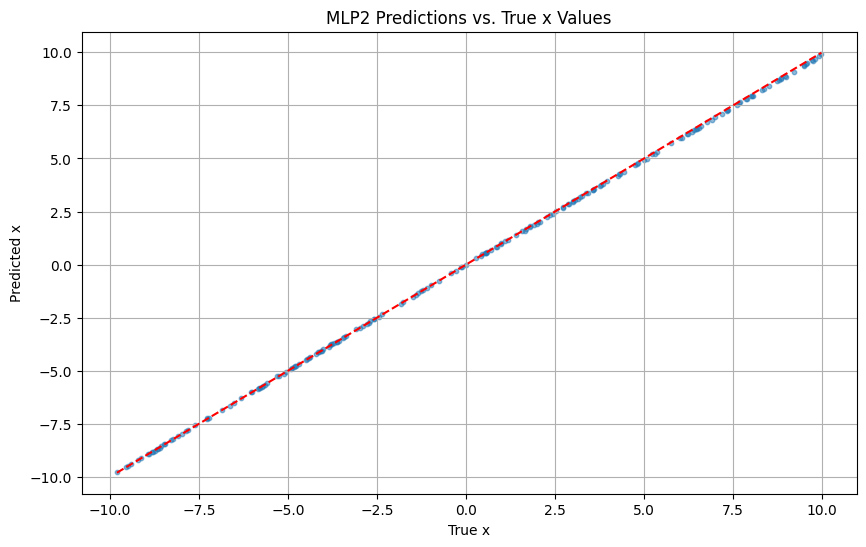

The InverseMLP has converged (validation loss decreased).


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

input_size_x = 1
output_size_y = 100
num_samples = 1000
noise_std = 0.1

data_generator = DataGenerator(input_size=input_size_x, output_size=output_size_y)

dataset = GeneratedDataset(generator=data_generator, num_samples=num_samples, noise_std=noise_std)

y_sample, x_sample = dataset[0]

print("\nStatistics of y (First Component):")
print(f"Mean: {dataset.y[:,0].mean().item():.4f}")
print(f"Std Dev: {dataset.y[:,0].std().item():.4f}")
print(f"Min: {dataset.y[:,0].min().item():.4f}")
print(f"Max: {dataset.y[:,0].max().item():.4f}")


X = dataset.y.numpy()
Y = dataset.x.numpy()
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

train_dataset_inv = torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                                torch.tensor(Y_train, dtype=torch.float32))
val_dataset_inv = torch.utils.data.TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                              torch.tensor(Y_val, dtype=torch.float32))
batch_size = 32
train_loader_inv = DataLoader(train_dataset_inv, batch_size=batch_size, shuffle=True)
val_loader_inv = DataLoader(val_dataset_inv, batch_size=batch_size, shuffle=False)

configurations = [
{'hidden_sizes': [100, 50], 'activation': 'ReLU', 'learning_rate': 0.01},
{'hidden_sizes': [200, 100], 'activation': 'Tanh', 'learning_rate': 0.001},
{'hidden_sizes': [300, 150, 75], 'activation': 'Sigmoid', 'learning_rate': 0.005},
{'hidden_sizes': [120, 60], 'activation': 'LeakyReLU', 'learning_rate': 0.01},
]

num_epochs = 100

for config in configurations:
  print(f"\nTraining InverseMLP with config: Hidden Sizes={config['hidden_sizes']}, Activation={config['activation']}, LR={config['learning_rate']}")

inverse_mlp = InverseMLP(input_size=output_size_y,
                          output_size=input_size_x,
                          hidden_sizes=config['hidden_sizes'],
                          activation=config['activation']).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(inverse_mlp.parameters(), lr=config['learning_rate'])

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss = train(inverse_mlp, train_loader_inv, criterion, optimizer, device)
    val_loss = validate(inverse_mlp, val_loader_inv, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if (epoch+1) % 20 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

plot_losses(train_losses, val_losses, config)

plot_predictions(inverse_mlp, val_loader_inv, device)

if val_losses[-1] < val_losses[0]:
    print("The InverseMLP has converged (validation loss decreased).")
else:
    print("The InverseMLP did not converge (validation loss did not decrease).")